In [1]:
from os import getcwd, makedirs, path as os_path
from sys import path as sys_path
sys_path.append(os_path.dirname(getcwd()))
sys_path.append(os_path.join(os_path.dirname(getcwd()), "../"))

In [3]:
from utils.file import load_json

trash_images = load_json("/mnt/data/src/dedup/trash.json")
len(trash_images)

440

In [4]:
from os.path import basename, dirname

def is_gt_trash(image_path):
    gt_group_type = str(basename(dirname(image_path)))
    if gt_group_type.startswith("kxd") or gt_group_type.startswith("kp"):
        return True

    return False

In [5]:
wrong_images = [x for x in trash_images if not is_gt_trash(x)]
len(wrong_images)

52

In [211]:
from utils.file import load_json

group_dict = load_json("/mnt/data/src/dedup/group.json")
group_images = sorted(group_dict.values(), key=lambda x: len(x), reverse=True)[1]
len(group_images)

45

## Create model

In [212]:
from ocr_run import OCR, get_weights

ocr = OCR(
    weight_detect=get_weights("/mnt/data/ocr/RELEASE_0.1.0/yolov8_text.pt", out_dir="../weights"),
    weight_reg=get_weights("/mnt/data/ocr/RELEASE_0.1.0/weight_transformer_0507.pth", out_dir="../weights"),
    config_reg=get_weights("/mnt/data/ocr/RELEASE_0.1.0/config_transformer.yml", out_dir="../weights"),
)

Weights is already located. No downloading.
Weights is already located. No downloading.
Weights is already located. No downloading.


In [213]:
# folder = "../test/in"
raw_res = ocr.detect(group_images)


image 1/1 /mnt/data/data/Data_Dedup/test_75+/kxd_253/1698365543625_0.jpg: 160x224 10 texts, 16.8ms
Speed: 0.6ms preprocess, 16.8ms inference, 1.4ms postprocess per image at shape (1, 3, 160, 224)

image 1/1 /mnt/data/data/Data_Dedup/test_75+/kxd_253/1698365550028_0.jpg: 64x224 24 texts, 7.6ms
Speed: 0.3ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 224)

image 1/1 /mnt/data/data/Data_Dedup/test_75+/kxd_253/1698365553228_1.jpg: 64x224 24 texts, 7.2ms
Speed: 0.3ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 224)

image 1/1 /mnt/data/data/Data_Dedup/test_75+/kxd_253/1698365554828_2.jpg: 64x224 27 texts, 7.2ms
Speed: 0.2ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 224)

image 1/1 /mnt/data/data/Data_Dedup/test_75+/kxd_253/1698365559630_0.jpg: 96x224 26 texts, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 224)

image 1/1 /mnt/data/data/Dat

## Extract name by bounding box

In [ ]:
vocab = "aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ "


def filter_characters(text: str, vocab: str) -> str:
    """Remove characters not in vocabulary"""
    return "".join([x for x in text if x in vocab])


def filter_text(result_value: list, vocab: str):
        for dr in result_value:
            dr.text = filter_characters(dr.text, vocab)

        result_value = [x for x in result_value if len(x.text) > 1]
        
        return result_value

In [ ]:
rv = raw_res["../test/in/1698302876103.jpg"]
rv = filter_text(rv, vocab)
rv[0].text

'TIẾN'

In [ ]:
# NOTE: not correct for rotated images
def is_same_row(
    bbox1: list | tuple, bbox2: list | tuple, bbox3: list | tuple | None
) -> bool:
    """Check if current bbox1 is on the same row as previous bbox2"""

    h1 = bbox1[3] - bbox1[1]
    h2 = bbox2[3] - bbox2[1]
    cx1 = (bbox1[2] + bbox1[0]) / 2
    cy1 = (bbox1[3] + bbox1[1]) / 2
    cx2 = (bbox2[2] + bbox2[0]) / 2
    cy2 = (bbox2[3] + bbox2[1]) / 2

    vdist = abs(cy1 - cy2)
    if not 0.75 * h2 <= h1 <= 1.25 * h2:
        return False

    if vdist <= 0.5 * h1 or vdist <= 0.5 * h2:
        return True

    if vdist <= 0.75 * h1 and vdist <= 0.75 * h2:
        if bbox3 is None:
            return True
        else:
            cx3 = (bbox3[2] + bbox3[0]) / 2
            prev_hdist = cx2 - cx3
            curr_hdist = cx1 - cx2
            return 0.9 * prev_hdist <= curr_hdist <= 1.1 * prev_hdist

    return False


def sort_by_bounding_boxes(data):
    """Sort a list of data by bounding box positions

    Args:
        data(list[tuple[list[str], str]]): Each tuple contains bounding box coordinates and text.
            Example: [([x_min, y_min, x_max, y_max], text)]

    Return:
        list[tuple[list[str], str]]: Sorted list of `data` parameter
    """
    if len(data) == 0:
        return data

    # Sort by the y_min value
    data = sorted(data, key=lambda item: item.xyxy[1])

    # Group by rows
    rows = []
    current_row = []
    current_bbox = data[0].xyxy
    prev_bbox = None

    for i, item in enumerate(data):
        bbox = item.xyxy

        if is_same_row(bbox, current_bbox, prev_bbox):
            current_row.append(item)
            if i >= 1:
                prev_bbox = data[i - 1].xyxy
        else:
            rows.append(current_row)
            current_row = [item]
            prev_bbox = None

        current_bbox = bbox

    # Don't forget to add the last row
    rows.append(current_row)

    # Sort all rows by the x_min value (left)
    for i, row in enumerate(rows):
        rows[i] = sorted(row, key=lambda item: item.xyxy[0])

    # sorted_data = [bbox for row in rows for bbox in row]
    return rows

In [ ]:
rv_rows = sort_by_bounding_boxes(rv)
# sorted_sample_names
[[x.text for x in row] for row in rv_rows]

[['TRUNG', 'TÂM', 'LAPTOP'], ['CHÍNH', 'HĂNG']]

In [ ]:
def filter_names(rows: list[list]):
    max_height_rows = [max(row, key=lambda x: x.height).height for row in rows]
    max_height = max(max_height_rows)    

    result = []
    for i, row in enumerate(rows):
        if max_height_rows[i] >= 0.7 * max_height:
            result.extend(row)

    return result

In [ ]:
rv = filter_names(rv_rows)
rv

[Khong co lam TT,
 Khong co lam TT,
 Khong co lam TT,
 Khong co lam TT,
 Khong co lam TT]

In [ ]:
def extract_names(rv: list, vocab: str) -> list[str]:
    rv_rows = sort_by_bounding_boxes(rv)
    rv_rows = [filter_text(row, vocab) for row in rv_rows]
    names = filter_names(rv_rows)

    return [x.text for x in names]

## Visualization

In [214]:
from utils.extractor import extract_names, extract_important_text

name_res = {key: extract_names(value) for key, value in raw_res.items()}
imp_res = {key: extract_important_text(value) for key, value in raw_res.items()}

In [2]:
from utils.file import load_object

string_dict = load_object("../out/segment/text.pkl")
list(string_dict.values())[0]

'ama coffee'

In [3]:
det_res = load_object("../out/detect/text.pkl")
list(det_res.values())[0]

'uama coffee nguyen thi lay non one o hieu'

In [215]:
from collections import Counter

def compare_list(list1, list2):
    return Counter(list1) == Counter(list2)

In [216]:
for i, (name, imp) in enumerate(zip(name_res.values(), imp_res.values())):
    if not compare_list(name, imp):
        print(f"{i}: {name} \t {imp}")

1: ['PHÚC', 'CÓ', 'CƠM', 'GÂ'] 	 ['CƠM', 'GÂ', 'CÓ']
7: ['PHÚC', 'CƠM', 'GÀ'] 	 ['CƠM', 'GÀ']


In [5]:
seg_res = string_dict
index = len(seg_res)

trung veston may day nha doi ve
nha veston trung may doi day ve nguyen 0918 trong tuyen 330 dt 932


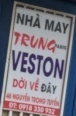

In [11]:
from PIL import Image

index = index - 1
print(list(seg_res.values())[index])
print(list(det_res.values())[index])
Image.open(list(det_res.keys())[index])